In [1]:
import pandas as pd
import os
import glob
from datetime import datetime

# 1. LOAD FILE LIST
# If you saved the CSV from the previous step:
# df = pd.read_csv("mea_file_locations.csv")

# OR, if you want to run it fresh right now:
root_search_path = "/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedData/CDKL5_T1"
files = glob.glob(os.path.join(root_search_path, "**", "*network*.json"), recursive=True)
df = pd.DataFrame(files, columns=['full_path'])

def parse_path_metadata(path):
    """
    Extracts metadata from the standard path structure:
    .../AnalyzedData/Genotype/Date/ChipID/Network/RunID/WellID/...
    """
    try:
        parts = path.split(os.sep)
        
        # We anchor everything relative to "AnalyzedData" to be safe
        if "AnalyzedData" in parts:
            idx = parts.index("AnalyzedData")
            
            # Extract based on your specific directory depth
            project = parts[idx + 1]  # e.g., CDKL5_T1
            date_str = parts[idx + 2]  # e.g., 240531
            chip_id  = parts[idx + 3]  # e.g., M07420
            # parts[idx + 4] is usually "Network"
            run_id   = parts[idx + 5]  # e.g., 000052
            well_id  = parts[idx + 6]  # e.g., well005
            
            return pd.Series([project, date_str, chip_id, run_id, well_id])
        else:
            return pd.Series([None, None, None, None, None])
            
    except IndexError:
        return pd.Series([None, None, None, None, None])

# 2. APPLY EXTRACTION
print(" dissecting path names...")
metadata_cols = ["Project", "Date", "Chip_ID", "RunID", "Well"]
df[metadata_cols] = df['full_path'].apply(parse_path_metadata)
#puth full_path to last column
df = df[[col for col in df.columns if col != 'full_path'] + ['full_path']]


# 4. REVIEW
print(f"Successfully dissected {len(df)} paths.")
print("\nSnapshot of extracted metadata:")
print(df.head())

# 5. SAVE
df.to_csv("/pscratch/sd/m/mpatil1/MEA_Analysis/IPNAnalysis/workbooks/mea_metadata_index.csv", index=False)

 dissecting path names...
Successfully dissected 366 paths.

Snapshot of extracted metadata:
    Project    Date Chip_ID   RunID     Well  \
0  CDKL5_T1  240607  M08018  000095  well000   
1  CDKL5_T1  240607  M08018  000095  well003   
2  CDKL5_T1  240607  M08018  000095  well004   
3  CDKL5_T1  240607  M08018  000095  well001   
4  CDKL5_T1  240607  M08018  000095  well002   

                                           full_path  
0  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  
1  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  
2  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  
3  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  
4  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  


In [2]:
import json
import pandas as pd

# 1. Select the first file from our dissected dataframe
# We use .iloc[0] to grab the first row
sample_path = df.iloc[0]['full_path']
#print(f"Inspecting file: {sample_path}\n")
#sample_path = '/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedData/CDKL5_T1/240531/M07420/Network/000052/well004/network_results.json'
# 2. Load the JSON data
with open(sample_path, 'r') as f:
    data = json.load(f)

# 3. Helper function to print the structure without flooding the screen
# This will show you the Keys and the Type of data inside (e.g., float, list of 6000 items)
def print_structure(d, indent=0):
    spacing = "  " * indent
    if isinstance(d, dict):
        for key, value in d.items():
            if isinstance(value, dict):
                print(f"{spacing}- {key}: (Nested Dictionary)")
                print_structure(value, indent + 1)
            elif isinstance(value, list):
                print(f"{spacing}- {key}: List [{len(value)} items]")
            else:
                print(f"{spacing}- {key}: {type(value).__name__} (e.g., {value})")
    else:
        print(f"{spacing} (Not a dictionary)")

# 4. Print the "Map" of your JSON
print("--- JSON FILE STRUCTURE ---")
print_structure(data)

# 5. Check for specific "Gold Mine" keys
# These are the standard keys usually found in MaxWell/MACS outputs.
# We try to print them specifically to see if they exist.
print("\n--- CHECKING FOR COMMON METRICS ---")
possible_keys = ['mean_firing_rate', 'mean_burst_rate', 'network_burst_frequency', 'burst_duration_mean']

found_metrics = {}
for key in possible_keys:
    # Check top level
    if key in data:
        found_metrics[key] = data[key]
    # Sometimes metrics are hidden inside a 'summary' or 'network' sub-dictionary
    elif 'summary' in data and key in data['summary']:
        found_metrics[key] = data['summary'][key]

print(f"Found specific metrics: {json.dumps(found_metrics, indent=2)}")

--- JSON FILE STRUCTURE ---
- unit_bursts: (Nested Dictionary)
  - 5: (Nested Dictionary)
    - bursts: List [148 items]
    - isis_all: List [925 items]
  - 6: (Nested Dictionary)
    - bursts: List [263 items]
    - isis_all: List [1669 items]
  - 18: (Nested Dictionary)
    - bursts: List [72 items]
    - isis_all: List [451 items]
  - 22: (Nested Dictionary)
    - bursts: List [79 items]
    - isis_all: List [464 items]
  - 23: (Nested Dictionary)
    - bursts: List [35 items]
    - isis_all: List [200 items]
  - 25: (Nested Dictionary)
    - bursts: List [39 items]
    - isis_all: List [272 items]
  - 27: (Nested Dictionary)
    - bursts: List [85 items]
    - isis_all: List [537 items]
  - 31: (Nested Dictionary)
    - bursts: List [17 items]
    - isis_all: List [172 items]
  - 32: (Nested Dictionary)
    - bursts: List [15 items]
    - isis_all: List [97 items]
  - 33: (Nested Dictionary)
    - bursts: List [30 items]
    - isis_all: List [235 items]
  - 34: (Nested Dictionary)

In [3]:
import json
import pandas as pd
import numpy as np
import os

# --- 1. SETUP & PROGRESS BAR ---
try:
    from tqdm import tqdm
    tqdm.pandas()
    # Assuming 'df' is your existing dataframe with file paths
    print("Progress bar enabled.")
except ImportError:
    def tqdm(x, **kwargs): return x
    print("Install 'tqdm' for a progress bar. Running standard loop...")

# --- 2. DEFINE UNIFIED EXTRACTION LOGIC ---
def extract_metrics(row):
    path = row['full_path']
    
    # A. Initialize dictionary with NaNs for scalars and empty lists for distributions
    metrics = {
        # --- SCALAR METRICS (For quick summaries) ---
        "num_units": np.nan,                 
        "nb_count": np.nan,
        "nb_rate_hz": np.nan,
        "nb_duration_mean_s": np.nan,        
        "nb_ibi_mean_s": np.nan,             
        "nb_spikes_per_burst_mean": np.nan,
        "nb_energy_mean": np.nan,            
        "psib": np.nan,                       
        
        # --- DISTRIBUTION LISTS (For your ANOVA/Tukey Plotting) ---
        "nb_durations_list": [],  # List of floats
        "nb_ibis_list": [],       # List of floats
        "nb_spikes_list": []    ,  # List of ints

        "sb_count": 0,                # Default to 0 (integer)
        "sb_duration_mean_s": np.nan, # Default to NaN
        "sb_spikes_mean": np.nan,
        
        # Distributions (for plotting)
        "sb_durations_list": [],      # Default to empty list
        "sb_spikes_list": []          # Default to empty list
    }

    try:
        with open(path, 'r') as f:
            data = json.load(f)
        
        # B. Extract Unit Counts
        if 'unit_bursts' in data:
            ub = data['unit_bursts']
            metrics["num_units"] = len(ub.keys()) if isinstance(ub, dict) else np.nan

        # C. Extract Network Stats (Scalars)
        if 'network_stats' in data:
            ns = data['network_stats']
            metrics["nb_count"] = ns.get('count')
            metrics["nb_rate_hz"] = ns.get('rate_hz')
            
            if 'duration' in ns:
                metrics["nb_duration_mean_s"] = ns['duration'].get('mean')
            
            if 'inter_burst_interval' in ns:
                metrics["nb_ibi_mean_s"] = ns['inter_burst_interval'].get('mean')
                
            if 'intensity' in ns:
                inte = ns['intensity']
                metrics["psib"] = inte.get('psib')
                if 'spikes' in inte:
                    metrics["nb_spikes_per_burst_mean"] = inte['spikes'].get('mean')
                if 'energy' in inte:
                    metrics["nb_energy_mean"] = inte['energy'].get('mean')

        # D. Extract Distributions (Lists for Plotting)
        # This iterates through every single burst to get the raw numbers
        if 'network_bursts' in data and isinstance(data['network_bursts'], list):
            for b in data['network_bursts']:
                # Append Duration
                if 'duration_s' in b:
                    metrics["nb_durations_list"].append(b['duration_s'])
                
                # Append IBI (Handle the fact the first burst might be None)
                if 'ibi_pre_s' in b:
                    val = b['ibi_pre_s']
                    if val is not None:
                        metrics["nb_ibis_list"].append(val)
                
                # Append Spike Counts
                if 'total_spikes' in b:
                    metrics["nb_spikes_list"].append(b['total_spikes'])

        # E. Extract Super Bursts if available
        # Check if key exists and is a list
        if 'superbursts' in data and isinstance(data['superbursts'], list):
            sb_list = data['superbursts']
            
            # 1. Update Count regardless of whether it's empty or full
            metrics["sb_count"] = len(sb_list)
            
            # 2. If list is NOT empty, extract details
            if len(sb_list) > 0:
                # Temporary lists for calculation
                durations = []
                spikes = []
                
                for sb in sb_list:
                    # Extract Duration
                    if 'duration_s' in sb:
                        durations.append(sb['duration_s'])
                        metrics["sb_durations_list"].append(sb['duration_s'])
                    
                    # Extract Spikes
                    if 'total_spikes' in sb:
                        spikes.append(sb['total_spikes'])
                        metrics["sb_spikes_list"].append(sb['total_spikes'])
                
                # 3. Calculate Summary Statistics (Scalars)
                # We use np.mean() if we have data, otherwise they stay NaN
                if durations:
                    metrics["sb_duration_mean_s"] = np.mean(durations)
                if spikes:
                    metrics["sb_spikes_mean"] = np.mean(spikes)

    except Exception as e:
        print(f"Error reading {path}: {e}")
        
    return pd.Series(metrics)

# --- 3. RUN EXTRACTION ---
print("Starting unified extraction (Scalars + Lists)...")

# If you have tqdm installed, use progress_apply, otherwise use apply
if hasattr(tqdm, 'pandas'):
    df_metrics = df.progress_apply(extract_metrics, axis=1)
else:
    df_metrics = df.apply(extract_metrics, axis=1)

# Concatenate metadata with results
result_df = pd.concat([df, df_metrics], axis=1)

# --- 4. MERGE WITH BIOLOGICAL METADATA (Crucial for Plotting) ---
# Load your cleaned map from the previous step
try:
    meta_path = "clean_metadata_map.csv" # Ensure this file exists from previous step
    if os.path.exists(meta_path):
        meta_df = pd.read_csv(meta_path)
        
        # Merge Results + Biology
        # We match on Date, Chip, and Well
        # Note: We rename columns to match your plotting function requirements immediately
        final_df = pd.merge(
            result_df, 
            meta_df, 
            left_on=['Date', 'Chip_ID', 'Well'], 
            right_on=['Date_Match', 'Chip_ID', 'WellID_Match'], 
            how='inner'
        )
        
        # Rename columns to match what your plotting function expects:
        # 'Genotype' -> 'NeuronType', 'ChipID' -> 'Chip_ID', 'WellID_Match' -> 'Well'
        final_df.rename(columns={
            'Genotype': 'NeuronType', 
            'ChipID': 'Chip_ID', 
            'WellID_Match': 'Well'
        }, inplace=True)
        
        print(f"\nMerge successful! Ready for plotting function.")
    else:
        print("\nWarning: 'clean_metadata_map.csv' not found. Data saved without biological metadata.")
        final_df = result_df
except Exception as e:
    print(f"Merge failed: {e}")
    final_df = result_df

# --- 5. SAVE ---
output_csv = "/pscratch/sd/m/mpatil1/MEA_Analysis/IPNAnalysis/workbooks/Network_Analysis_Master_Full.csv"
final_df.to_csv(output_csv, index=False)
print(f"Master table saved to: {output_csv}")

# Preview relevant columns for plotting
cols_to_show = ['DIV', 'NeuronType', 'nb_rate_hz', 'nb_durations_list']
print("\nPreview:")
print(final_df[cols_to_show].head() if 'NeuronType' in final_df.columns else final_df.head())

Progress bar enabled.
Starting unified extraction (Scalars + Lists)...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:45<00:00,  8.02it/s]



Master table saved to: /pscratch/sd/m/mpatil1/MEA_Analysis/IPNAnalysis/workbooks/Network_Analysis_Master_Full.csv

Preview:
    Project    Date Chip_ID   RunID     Well  \
0  CDKL5_T1  240607  M08018  000095  well000   
1  CDKL5_T1  240607  M08018  000095  well003   
2  CDKL5_T1  240607  M08018  000095  well004   
3  CDKL5_T1  240607  M08018  000095  well001   
4  CDKL5_T1  240607  M08018  000095  well002   

                                           full_path  num_units  nb_count  \
0  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...        262        80   
1  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...        174       100   
2  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...         96       122   
3  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...        107        46   
4  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...        138        86   

   nb_rate_hz  nb_duration_mean_s  ...  nb_energy_mean       psib  \
0    0.266598            1.052875  ...      156.132277

In [4]:
final_df.columns

Index(['Project', 'Date', 'Chip_ID', 'RunID', 'Well', 'full_path', 'num_units',
       'nb_count', 'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_spikes_per_burst_mean', 'nb_energy_mean', 'psib',
       'nb_durations_list', 'nb_ibis_list', 'nb_spikes_list', 'sb_count',
       'sb_duration_mean_s', 'sb_spikes_mean', 'sb_durations_list',
       'sb_spikes_list'],
      dtype='object')

In [5]:
ref_df = pd.read_excel("/pscratch/sd/m/mpatil1/Data/CDKL5_T1/CDKL5_T1_C1_reff.xlsx")
print(ref_df.columns)




# --- 2. TRANSFORMATION LOGIC ---

# Step A: Split the strings into actual Python lists
# We split by comma and implicitly handle the 1:1 mapping
ref_df['Wells_List'] = ref_df['Wells_Recorded'].astype(str).str.split(',')
ref_df['Source_List'] = ref_df['Neuron Source'].astype(str).str.split(',')

# Step B: Explode the lists into rows
# Pandas >= 1.3.0 allows exploding multiple columns simultaneously to keep them aligned
# This is crucial so Index 0 of Wells stays with Index 0 of Source
exploded_df = ref_df.explode(['Wells_List', 'Source_List'])

# Step C: Cleanup
# Remove whitespace that might exist in the strings (e.g., " MxWT" -> "MxWT")
exploded_df['Well'] = exploded_df['Wells_List'].str.strip()
exploded_df['NeuronType'] = exploded_df['Source_List'].str.strip()

# Step D: Create a "Match Key" for merging with your JSON results
# Your files are named like 'well005', so we format the number '5' -> 'well005'
exploded_df['Well'] = 'well' + exploded_df['Well'].str.zfill(3)

# Filter to keep only the clean columns
clean_ref_df = exploded_df[['Date', 'ID', 'Run #','Well', 'NeuronType', 'Assay', 'DIV']]

# --- 3. VIEW RESULTS ---
print(f"Transformation complete.")
print(f"Original rows: {len(ref_df)}")
print(f"Exploded rows: {len(clean_ref_df)}")
print("\nFirst 10 rows of clean metadata:")
print(clean_ref_df.head(10))

# Save this for the next step
#clean_ref_df.to_csv("clean_metadata_map.csv", index=False)

Index(['Date', 'DIV', 'Assay', 'Run #', 'ID', 'Wells_Recorded',
       'Neuron Source'],
      dtype='object')
Transformation complete.
Original rows: 109
Exploded rows: 654

First 10 rows of clean metadata:
        Date      ID  Run #     Well NeuronType          Assay  DIV
0 2024-05-20  M07420      1  well001       MxWT       Sparse7x    5
0 2024-05-20  M07420      1  well002       MxWT       Sparse7x    5
0 2024-05-20  M07420      1  well003       MxWT       Sparse7x    5
0 2024-05-20  M07420      1  well004      FxHET       Sparse7x    5
0 2024-05-20  M07420      1  well005      FxHET       Sparse7x    5
0 2024-05-20  M07420      1  well006      FxHET       Sparse7x    5
1 2024-05-20  M07420      2  well001       MxWT  Network Today    5
1 2024-05-20  M07420      2  well002       MxWT  Network Today    5
1 2024-05-20  M07420      2  well003       MxWT  Network Today    5
1 2024-05-20  M07420      2  well004      FxHET  Network Today    5


In [6]:

final_df.rename(columns={"ChipID": "Chip_ID"}, inplace=True)
final_df.rename(columns={"RunID": "Run #"}, inplace=True)

In [7]:
final_df.head()

,Project,Date,Chip_ID,Run #,Well,full_path,num_units,nb_count,nb_rate_hz,nb_duration_mean_s,...,nb_energy_mean,psib,nb_durations_list,nb_ibis_list,nb_spikes_list,sb_count,sb_duration_mean_s,sb_spikes_mean,sb_durations_list,sb_spikes_list
0,CDKL5_T1,240607,M08018,000095,well000,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,262,80,0.266598,1.052875,...,156.132277,49.580040,"[0.79, 1.7599999999999998, 1.4699999999999989,...","[0.9299999999999997, 3.24, 0.8000000000000007,...","[902, 1732, 1597, 997, 1458, 756, 681, 1039, 5...",5,3.300000,2743.400000,"[3.4799999999999995, 3.1500000000000004, 3.510...","[2634, 2594, 2214, 3289, 2986]"
1,CDKL5_T1,240607,M08018,000095,well003,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,174,100,0.333248,1.146900,...,98.037338,60.559541,"[0.7799999999999998, 1.8100000000000005, 1.939...","[0.5100000000000002, 2.7299999999999995, 3.139...","[510, 1165, 1534, 1418, 1431, 1885, 923, 263, ...",14,3.766429,2369.214286,"[3.1000000000000005, 3.049999999999997, 4.4399...","[1675, 1615, 2302, 3373, 3002, 2098, 2409, 115..."
2,CDKL5_T1,240607,M08018,000095,well004,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,96,122,0.406567,0.617213,...,14.636531,42.053543,"[0.2999999999999998, 0.5599999999999996, 0.740...","[0.9800000000000004, 0.9899999999999993, 2.960...","[107, 263, 369, 228, 300, 140, 332, 242, 260, ...",6,3.796667,761.500000,"[3.5699999999999994, 3.110000000000003, 4.4399...","[739, 714, 774, 722, 752, 868]"
3,CDKL5_T1,240607,M08018,000095,well001,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,107,46,0.153315,0.419565,...,23.196293,7.876058,"[0.3199999999999994, 0.38000000000000256, 0.53...","[13.120000000000001, 3.729999999999997, 2.2900...","[242, 257, 458, 346, 184, 277, 168, 295, 340, ...",0,NaN,NaN,[],[]
4,CDKL5_T1,240607,M08018,000095,well002,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,138,86,0.286597,0.742907,...,67.987407,47.981669,"[0.9900000000000002, 0.38000000000000256, 0.96...","[6.379999999999999, 3.6499999999999986, 2.9799...","[777, 265, 1178, 280, 671, 256, 851, 1492, 418...",0,NaN,NaN,[],[]


In [12]:
clean_ref_df.rename(columns={"ID": "Chip_ID"}, inplace=True)

/tmp/ipykernel_1118240/3319131171.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_ref_df.rename(columns={"ID": "Chip_ID"}, inplace=True)


In [13]:
#make Run # elemets to int
final_df['Run #'] = final_df['Run #'].astype(int)

In [14]:
#merge on ID and WellID and Run #
merged_df = pd.merge(final_df, clean_ref_df, how='left', left_on=['Chip_ID', 'Well', 'Run #'], right_on=['Chip_ID', 'Well', 'Run #'])


In [15]:
merged_df.head()

,Project,Date_x,Chip_ID,Run #,Well,full_path,num_units,nb_count,nb_rate_hz,nb_duration_mean_s,...,nb_spikes_list,sb_count,sb_duration_mean_s,sb_spikes_mean,sb_durations_list,sb_spikes_list,Date_y,NeuronType,Assay,DIV
0,CDKL5_T1,240607,M08018,95,well000,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,262,80,0.266598,1.052875,...,"[902, 1732, 1597, 997, 1458, 756, 681, 1039, 5...",5,3.300000,2743.400000,"[3.4799999999999995, 3.1500000000000004, 3.510...","[2634, 2594, 2214, 3289, 2986]",NaT,NaN,NaN,NaN
1,CDKL5_T1,240607,M08018,95,well003,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,174,100,0.333248,1.146900,...,"[510, 1165, 1534, 1418, 1431, 1885, 923, 263, ...",14,3.766429,2369.214286,"[3.1000000000000005, 3.049999999999997, 4.4399...","[1675, 1615, 2302, 3373, 3002, 2098, 2409, 115...",2024-06-07,FxHET,Neuronal Units 9,23.0
2,CDKL5_T1,240607,M08018,95,well004,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,96,122,0.406567,0.617213,...,"[107, 263, 369, 228, 300, 140, 332, 242, 260, ...",6,3.796667,761.500000,"[3.5699999999999994, 3.110000000000003, 4.4399...","[739, 714, 774, 722, 752, 868]",2024-06-07,MxHEMI,Neuronal Units 9,23.0
3,CDKL5_T1,240607,M08018,95,well001,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,107,46,0.153315,0.419565,...,"[242, 257, 458, 346, 184, 277, 168, 295, 340, ...",0,NaN,NaN,[],[],2024-06-07,MxHEMI,Neuronal Units 9,23.0
4,CDKL5_T1,240607,M08018,95,well002,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,138,86,0.286597,0.742907,...,"[777, 265, 1178, 280, 671, 256, 851, 1492, 418...",0,NaN,NaN,[],[],2024-06-07,MxWT,Neuronal Units 9,23.0


In [16]:
#keep only DateX and delete Date_y
merged_df.drop(columns=['Date_y'], inplace=True)
merged_df.rename(columns={"Date_x": "Date"}, inplace=True)

In [17]:
#order by run #
merged_df.sort_values(by=['Chip_ID', 'Run #', 'Well'], inplace=True)

In [18]:
merged_df.head()

,Project,Date,Chip_ID,Run #,Well,full_path,num_units,nb_count,nb_rate_hz,nb_duration_mean_s,...,nb_ibis_list,nb_spikes_list,sb_count,sb_duration_mean_s,sb_spikes_mean,sb_durations_list,sb_spikes_list,NeuronType,Assay,DIV
232,CDKL5_T1,240520,M07039,6,well000,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,454,26,0.086663,0.876538,...,"[16.599999999999994, 2.6099999999999994, 7.149...","[2723, 382, 1032, 619, 348, 1215, 1090, 304, 3...",0,NaN,NaN,[],[],NaN,NaN,NaN
235,CDKL5_T1,240520,M07039,6,well001,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,389,1,0.003333,0.940000,...,[],[2005],0,NaN,NaN,[],[],MxHEMI,Network Today,5.0
236,CDKL5_T1,240520,M07039,6,well002,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,305,12,0.040000,0.860833,...,"[18.500000000000007, 5.1499999999999915, 24.75...","[547, 281, 543, 530, 446, 612, 1781, 475, 1544...",0,NaN,NaN,[],[],MxWT,Network Today,5.0
233,CDKL5_T1,240520,M07039,6,well003,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,388,19,0.063335,0.934211,...,"[23.41, 24.579999999999995, 15.29, 4.290000000...","[2095, 770, 1674, 1173, 450, 217, 675, 324, 10...",0,NaN,NaN,[],[],FxHET,Network Today,5.0
234,CDKL5_T1,240520,M07039,6,well004,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,389,1,0.003333,0.950000,...,[],[2435],0,NaN,NaN,[],[],MxHEMI,Network Today,5.0


In [19]:
#Calcuate DIV based on Date and Date of plating
plating_date = '240515'
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%y%m%d')
plating_date_dt = pd.to_datetime(plating_date, format='%y%m%d')
merged_df['DIV'] = (merged_df['Date'] - plating_date_dt).dt.days
merged_df.head()

,Project,Date,Chip_ID,Run #,Well,full_path,num_units,nb_count,nb_rate_hz,nb_duration_mean_s,...,nb_ibis_list,nb_spikes_list,sb_count,sb_duration_mean_s,sb_spikes_mean,sb_durations_list,sb_spikes_list,NeuronType,Assay,DIV
232,CDKL5_T1,2024-05-20,M07039,6,well000,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,454,26,0.086663,0.876538,...,"[16.599999999999994, 2.6099999999999994, 7.149...","[2723, 382, 1032, 619, 348, 1215, 1090, 304, 3...",0,NaN,NaN,[],[],NaN,NaN,5
235,CDKL5_T1,2024-05-20,M07039,6,well001,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,389,1,0.003333,0.940000,...,[],[2005],0,NaN,NaN,[],[],MxHEMI,Network Today,5
236,CDKL5_T1,2024-05-20,M07039,6,well002,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,305,12,0.040000,0.860833,...,"[18.500000000000007, 5.1499999999999915, 24.75...","[547, 281, 543, 530, 446, 612, 1781, 475, 1544...",0,NaN,NaN,[],[],MxWT,Network Today,5
233,CDKL5_T1,2024-05-20,M07039,6,well003,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,388,19,0.063335,0.934211,...,"[23.41, 24.579999999999995, 15.29, 4.290000000...","[2095, 770, 1674, 1173, 450, 217, 675, 324, 10...",0,NaN,NaN,[],[],FxHET,Network Today,5
234,CDKL5_T1,2024-05-20,M07039,6,well004,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,389,1,0.003333,0.950000,...,[],[2435],0,NaN,NaN,[],[],MxHEMI,Network Today,5


In [20]:
merged_df.columns

Index(['Project', 'Date', 'Chip_ID', 'Run #', 'Well', 'full_path', 'num_units',
       'nb_count', 'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_spikes_per_burst_mean', 'nb_energy_mean', 'psib',
       'nb_durations_list', 'nb_ibis_list', 'nb_spikes_list', 'sb_count',
       'sb_duration_mean_s', 'sb_spikes_mean', 'sb_durations_list',
       'sb_spikes_list', 'NeuronType', 'Assay', 'DIV'],
      dtype='object')

In [21]:
!pip install statsmodels --user

In [22]:
from math import sqrt
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
df = merged_df.copy()
output_types = ['num_units', 'nb_count',
       'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_spikes_per_burst_mean', 'nb_energy_mean', 'psib', 'sb_count',
       'sb_duration_mean_s', 'sb_spikes_mean']

div = sorted(df['DIV'].unique())

unique_genotypes = [ 'MxWT', 'FxHET' ,'MxHEMI']

colors = ['blue','orange','red']
markers = ['o','o','d','*','^']

#dirpath = '/mnt/disk15tb/paula/Main_DA_Projects/data_analysis_output/Primary Neurons/CDKL5_E6T1_Apr29/plots/'
for output_type in output_types:
    total_genotypes = len(unique_genotypes)
    #output_type='Number_Bursts'
    # Print the number of unique genotypes
    print(f"Number of unique Genotypes: {total_genotypes}")

    # Initialize output arrays for each unique genotype
    output_arrays = {genotype: [] for genotype in unique_genotypes}
    chip_arrays = {genotype: [] for genotype in unique_genotypes}
    well_arrays = {genotype: [] for genotype in unique_genotypes}
    print(unique_genotypes)
    # Fill data from data frame
    for i in div:
        for genotype in unique_genotypes:
            temp_df = df.loc[(df['DIV'] == i) &
                            (df['Neuron Source'].str.strip() == genotype)
                            ]
            output_arrays[genotype].append(np.array(temp_df[output_type]))
            chip_arrays[genotype].append(np.array(temp_df['ID']))
            well_arrays[genotype].append(np.array(temp_df['WellID']))
    #print(df)
    # Adjust bar width and gap between them
    bar_width = 0.25  # Adjust as necessary for your specific plot
    gap_between_bars = 0  # Adjust the gap between bars within a group

    # Calculate the total width for all bars in a group
    total_bar_group_width = total_genotypes * bar_width + (total_genotypes - 1) * gap_between_bars

    # Create x-coordinates of bars for each genotype group
    x_genotype = {genotype: [] for genotype in unique_genotypes}
    base_x_coordinate = np.arange(len(div))  # Base x-coordinates for each group
    offset = (total_genotypes * bar_width + (total_genotypes - 1) * gap_between_bars) / 2
    centered_x = base_x_coordinate - offset + bar_width / 2
    for i, genotype in enumerate(unique_genotypes):
        x_genotype[genotype] = centered_x + i * (bar_width + gap_between_bars)



    # Initialize plot
    fig, ax = plt.subplots()
    # Generate a list of distinct colors based on the number of genotypes
    #colors = [plt.colormaps['Set1'](i) for i in np.linspace(0, 1, len(unique_genotypes))]# Using a colormap to generate colors
    #colors2 = [plt.colormaps['Set2'](i) for i in np.linspace(0, 1, len(unique_genotypes))]#
    # marker_shapes = ['^', 's', 'v', 'D', '+', 'x', '*', 'H', '8']
    # marker_chips={chip:marker_shapes[idx] for idx, chip in enumerate(track_chips)}
    # Plot data for each genotype
    mean_data_all ={}
    yerr_data_all = {}
    n_data_all={}
    #breakpoint()
    #pdb.set_trace()
    for i,genotype in enumerate(unique_genotypes):
        #breakpoint()
        y_data = output_arrays[genotype]
        chipy_data = chip_arrays[genotype]
        welly_data = well_arrays[genotype]
        #print("type: ",type(genotype))
        # Calculate statistics
        mean_data = [np.mean([n for n in yi if np.isfinite(n)]) for yi in y_data]
        yerr_data = [np.std([n for n in yi if np.isfinite(n)], ddof=1)/np.sqrt(np.size(yi)) for yi in y_data]
        n_data = [len(yi) for yi in y_data]
        # Store statistics in dictionaries
        mean_data_all[genotype] = mean_data
        yerr_data_all[genotype] = yerr_data
        n_data_all[genotype] = n_data
        
            
        # Plot bars
        #transparency value 
        alpha_value = 0.5
        ax.bar(x_genotype[genotype], mean_data, yerr=yerr_data, capsize=3, width=bar_width, color=colors[i], edgecolor=colors[i], ecolor='black', label=genotype,alpha=1.0)

        #pdb.set_trace()
        # Plot scatter points
        #breakpoint()
        for j in range(len(x_genotype[genotype])):
            #pdb.set_trace()
            # ax.scatter(x_genotype[genotype][j] + np.zeros(y_data[j].size), y_data[j], s=20,color=colors2[i],marker=marker_chips[chipy_data[j]+str(welly_data[j])] if chipy_data[j]+str(welly_data[j]) in track_chips else 'o')
    # Concatenate corresponding elements from chipy_data[j] and welly_data[j]
            combined_data = [str(chip)+ str(well) for chip, well in zip(chipy_data[j], welly_data[j])]

            # # Check if the concatenated string is in track_chips, and set the marker accordingly
            # markers = [marker_chips.get(chipwell, 'o') for chipwell in combined_data]
            # #marker_chips[combined_data[0]] if combined_data[0] in track_chips else 'o'

            # Use the marker in the scatter plot
            jitter_amount=0.08
            for k in range(len(y_data[j])):
                #pdb.set_trace()
                ax.scatter(
                    x_genotype[genotype][j] + np.random.uniform(-jitter_amount, jitter_amount, 1),
                    y_data[j][k],
                    s=20,
                    color='white',
                    marker='o',
                    edgecolors='black'
                        )


    # # Calculate maximum y-value for plotting significance
    # max_y = max([max(data) for data in output_arrays.values() if data.size > 0])
    # increment = max_y * 0.1  # Increment to adjust y-position for significance markers

    #Perform and plot t-tests between all pairs of genotype
    #pdb.set_trace()
    for i in range(len(base_x_coordinate)):
        #maxim = max([max( output_arrays[genotype][i] )for genotype in unique_genotypes])
        maxim = max(max(array) for genotype_arrays in output_arrays.values() for array in genotype_arrays)
        count = 1
        p_values = []
        for j, genotype1 in enumerate(unique_genotypes):
            for k, genotype2 in enumerate(unique_genotypes):
                if j < k:
                    #pdb.set_trace()
                    #print("mean_data_all",mean_data_all[genotype1])
                    #print("type:",type(genotype1))
                    mean1, sem1, n1 = mean_data_all[genotype1][i], yerr_data_all[genotype1][i], n_data_all[genotype1][i]
                    mean2, sem2, n2 = mean_data_all[genotype2][i], yerr_data_all[genotype2][i], n_data_all[genotype2][i]
                    #t_stat, p_value = stats.ttest_ind_from_stats(mean1, sem1, n1, mean2, sem2, n2)
                    sed = sqrt(sem1**2.0 + sem2**2.0)
                    t_stat = (mean1 - mean2) / sed
                    # degrees of freedom
                    degreef = n1+n2 - 2
                    alpha=0.05
                    # calculate the critical value
                    cv = stats.t.ppf(1.0 - alpha, degreef)
                    # calculate the p-vallue
                    p_value = (1.0 - stats.t.cdf(abs(t_stat), degreef)) * 2.0
                    p_values.append([mean1,sem1,mean2,sem2,p_value])

                    # Plot significance
                    #maxim = max(np.max(output_arrays[genotype1][i]), np.max(output_arrays[genotype2][i]))
                    x1, x2 = x_genotype[genotype1][i], x_genotype[genotype2][i]
                    
                    sign = "***" if p_value <= 0.001 else "**" if p_value <= 0.01 else "*" if p_value <= 0.05 else "ns"
                    if not sign =='ns':
                        ax.plot([x1, x2], [maxim + 0.05*maxim*(count)] * 2, 'k', linewidth=1.5)
                        ax.text((x1 + x2) / 2, maxim +0.05*maxim*(count), sign, ha='center', va='bottom', fontsize=7)
                        ax.axvline(x1,color='black',linestyle=':',linewidth=0.5)
                        ax.axvline(x2,color='black',linestyle=':',linewidth=0.5)
                    count = count +1

                    


   # Adjustments for plot aesthetics
    plt.title(f"{output_type}", fontsize=14)
    plt.xlabel('DIV', fontsize=12)
    plt.ylabel(f"{output_type}", fontsize=12)
    plt.xticks(base_x_coordinate, div, fontsize=10)

    plt.legend(title='NeuronType', loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    plt.tight_layout() 
    plt.show() # Adjust layout to prevent clipping of ylabel
    #plt.legend(title='NeuronType',loc='upper right', fontsize='x-small', handlelength=2, handletextpad=2, handleheight=2,bbox_to_anchor=(1.0, 1))
   # import os 
    
    #if not os.path.exists(dirpath):
    #        os.makedirs(dirpath)
    #plt.savefig(f"{dirpath}/{output_type}.svg",dpi=300,format='svg')

Number of unique Genotypes: 3
['MxWT', 'FxHET', 'MxHEMI']


KeyError: 'Neuron Source'

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import sem
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

plt.rcParams.update({
    "font.family": "Arial",
    "axes.edgecolor": "black",
    "axes.linewidth": 1.0,
    "axes.labelsize": 14,
    "axes.labelweight": "bold",
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "legend.title_fontsize": 13,
    "xtick.direction": "out",
    "ytick.direction": "out"
})

def plot_feature_line_anova_tukey(
    df,
    list_col,
    feature_label=None,
    order=('MxWT','FxHET','MxHEMI'),
    palette={'MxWT':'#1f77b4','FxHET':'#c77b1b','MxHEMI':'#d62728'},
    save_path=None
):
    """Publication-quality lineplot of per-well mean metric across DIVs with ANOVA + Tukey"""

    # 1) Convert list column → numeric list
    num_col = f"{list_col}_Numeric"
    if num_col not in df.columns:
        df[num_col] = df[list_col].apply(
            lambda x: x if isinstance(x,list)
            else [float(i) for i in str(x).split(',')] if pd.notnull(x) else [])

    # 2) Build long form
    long_df = df[['DIV', 'Well', 'Chip_ID', 'NeuronType', num_col]].copy()
    long_df = long_df.rename(columns={num_col: 'Value_List'})
    long_df['ChipID_Well'] = long_df['Chip_ID'].astype(str) + '_W' + long_df['Well'].astype(str)
    long_df = long_df.explode('Value_List').reset_index(drop=True)
    long_df['Value'] = pd.to_numeric(long_df['Value_List'], errors='coerce')
    long_df.dropna(subset=['Value'], inplace=True)

    # 3) Aggregate mean per ChipID_Well × NeuronType × DIV
    agg_df = long_df.groupby(['DIV','ChipID_Well','NeuronType']).agg(mean_value=('Value','mean')).reset_index()

    # 4) Compute group summary (mean ± SEM)
    summary = (
        agg_df
        .groupby(['DIV','NeuronType'])
        .agg(mean_value=('mean_value','mean'), sem_value=('mean_value',sem))
        .reset_index()
    )

    divs = sorted(agg_df['DIV'].unique())
    group_offsets = {'MxWT': -0.5, 'FxHET': 0.0, 'MxHEMI': 0.5}

    # 5) Plot setup
    fig, ax = plt.subplots(figsize=(8, 4.8))

    # Scatter per well (background)
    for nt, color in palette.items():
        sub = agg_df[agg_df['NeuronType'] == nt]
        jitter = (np.random.rand(len(sub)) - 0.5) * 0.15
        ax.scatter(sub['DIV'] + jitter + group_offsets[nt],
                   sub['mean_value'], color=color, alpha=0.5, s=18, edgecolor='none')

    # Mean ± SEM lines (main layer)
    for nt, color in palette.items():
        sub = summary[summary['NeuronType'] == nt]
        offset = group_offsets[nt]
        ax.plot(sub['DIV'] + offset, sub['mean_value'], '-o',
                color=color, lw=3, zorder=3, label=nt)
        ax.fill_between(sub['DIV'] + offset,
                        sub['mean_value'] - sub['sem_value'],
                        sub['mean_value'] + sub['sem_value'],
                        color=color, alpha=0.25, zorder=2)

    # 6) ANOVA + Tukey tests per DIV
    tukey_sig = []
    for div in divs:
        sub = agg_df[agg_df['DIV'] == div]
        if sub['NeuronType'].nunique() < 2:
            continue
        model = ols('mean_value ~ C(NeuronType)', data=sub).fit()
        anova_results = anova_lm(model, typ=2)
        if 'C(NeuronType)' not in anova_results.index:
            continue
        p_anova = anova_results.loc['C(NeuronType)', 'PR(>F)']

        tuk = pairwise_tukeyhsd(sub['mean_value'], sub['NeuronType'], alpha=0.05)
        results_df = pd.DataFrame(tuk._results_table.data[1:], columns=tuk._results_table.data[0])

        for _, row in results_df.iterrows():
            if row['reject']:
                tukey_sig.append((div, row['group1'], row['group2'], float(row['p-adj'])))

    # --- IMPROVED SIGNIFICANCE ANNOTATIONS ---
    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin
    ax.set_ylim(ymin, ymax + yrange * 0.22)

    for div in divs:
        sig_pairs = [(d, s1, s2, p) for (d, s1, s2, p) in tukey_sig if d == div]
        if not sig_pairs:
            continue

        # Sort so that strongest (lowest p) is plotted on top
        sig_pairs.sort(key=lambda x: x[3])

        for k, (_, s1, s2, p_adj) in enumerate(sig_pairs):
            if p_adj < 0.001:
                sig = '***'
            elif p_adj < 0.01:
                sig = '**'
            elif p_adj < 0.05:
                sig = '*'
            else:
                continue

            # Horizontal alignment
            x1 = div + group_offsets[s1]
            x2 = div + group_offsets[s2]

            # Vertical positioning (scaled dynamically)
            base = ymax * 1.01 + (yrange * 0.05 * k)
            h = yrange * 0.015

            # Draw bracket + star
            ax.plot([x1, x1, x2, x2],
                    [base, base + h, base + h, base],
                    lw=0.9, c='k', clip_on=False)

            ax.text((x1 + x2) / 2, base + h * 1.25, sig,
                    ha='center', va='bottom',
                    fontsize=11, fontweight='bold',
                    color='k', clip_on=False)
    # 8) Final aesthetics
    ax.legend(title='Neuron Type', frameon=False, loc='upper left', bbox_to_anchor=(1.02, 1))
    ax.set_xlabel('Days In Vitro (DIV)', weight='bold')
    ax.set_ylabel(feature_label or list_col.replace('_', ' '), weight='bold')
    ax.tick_params(axis='both', labelsize=12, direction='out', length=4, width=1)
    ax.set_xticks(divs)
    ax.grid(alpha=0.2, linestyle='--', linewidth=0.5)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()



In [24]:
merged_df.columns

Index(['Project', 'Date', 'Chip_ID', 'Run #', 'Well', 'full_path', 'num_units',
       'nb_count', 'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_spikes_per_burst_mean', 'nb_energy_mean', 'psib',
       'nb_durations_list', 'nb_ibis_list', 'nb_spikes_list', 'sb_count',
       'sb_duration_mean_s', 'sb_spikes_mean', 'sb_durations_list',
       'sb_spikes_list', 'NeuronType', 'Assay', 'DIV'],
      dtype='object')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

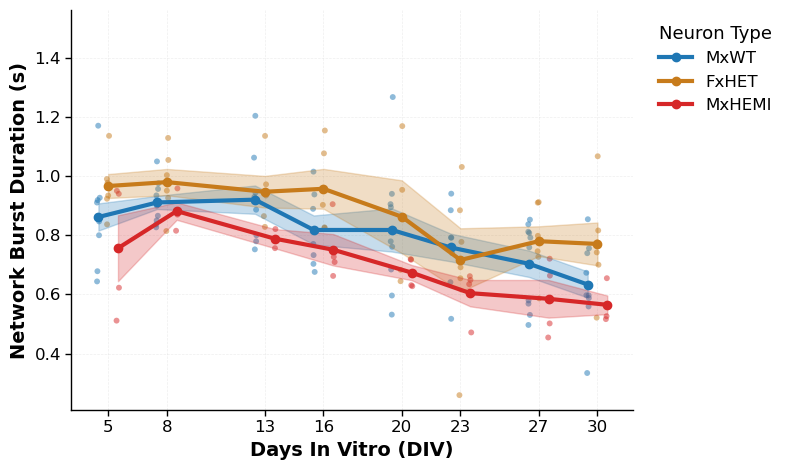

In [23]:
# Example usage
plot_feature_line_anova_tukey(
    df=merged_df,
    list_col='nb_durations_list', # The new list column we just extracted
    feature_label='Network Burst Duration (s)',
    order=('MxWT', 'FxHET', 'MxHEMI') # Ensure these match your CSV exactly
)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

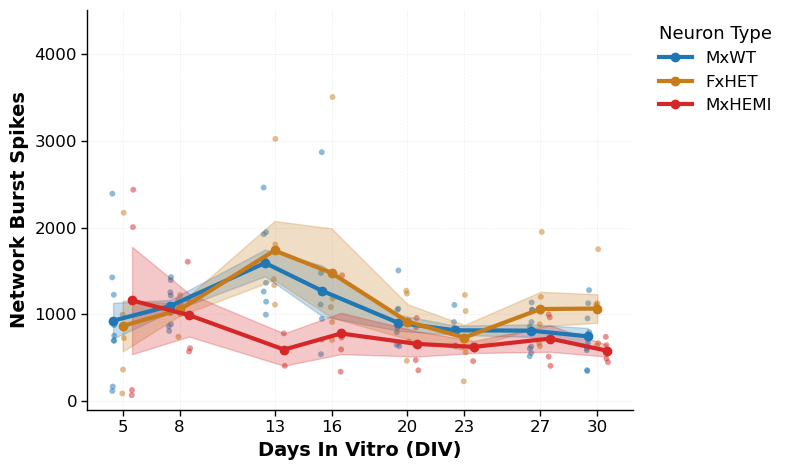

In [24]:
# Example usage
plot_feature_line_anova_tukey(
    df=merged_df,
    list_col='nb_spikes_list', # The new list column we just extracted
    feature_label='Network Burst Spikes',
    order=('MxWT', 'FxHET', 'MxHEMI') # Ensure these match your CSV exactly
)

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import sem
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

plt.rcParams.update({
    "font.family": "Arial",
    "axes.edgecolor": "black",
    "axes.linewidth": 1.0,
    "axes.labelsize": 14,
    "axes.labelweight": "bold",
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "legend.title_fontsize": 13,
    "xtick.direction": "out",
    "ytick.direction": "out"
})


def plot_scalar_line_anova_tukey(
    df,
    value_col,
    feature_label=None,
    order=('MxWT', 'FxHET', 'MxHEMI'),
    palette={'MxWT': '#1f77b4', 'FxHET': '#c77b1b', 'MxHEMI': '#d62728'},
    save_path=None
):
    """Publication-quality lineplot for scalar per-well features (e.g., firing rate, amplitude)"""

    sub = df[['DIV', 'NeuronType', 'Chip_ID', 'Well', value_col]].copy()
    sub['ChipID_Well'] = sub['Chip_ID'].astype(str) + '_W' + sub['Well'].astype(str)
    sub = sub[sub['ChipID_Well'] != 'M07420_1']
    sub = sub.dropna(subset=[value_col])
    if sub.empty:
        print(f"No data for {value_col}; skipping.")
        return

    # Aggregate per independent well
    agg_df = sub.groupby(['DIV', 'ChipID_Well', 'NeuronType'])[value_col].mean().reset_index()

    # Compute group summary
    summary = (
        agg_df.groupby(['DIV', 'NeuronType'])
        .agg(mean_value=(value_col, 'mean'), sem_value=(value_col, sem))
        .reset_index()
    )

    divs = sorted(agg_df['DIV'].unique())
    group_offsets = {'MxWT': -0.5, 'FxHET': 0.0, 'MxHEMI': 0.5}

    # Figure setup
    fig, ax = plt.subplots(figsize=(8, 4.8))

    # Scatter per well (background)
    for nt, color in palette.items():
        sub_nt = agg_df[agg_df['NeuronType'] == nt]
        jitter = (np.random.rand(len(sub_nt)) - 0.5) * 0.15
        ax.scatter(sub_nt['DIV'] + jitter + group_offsets[nt],
                   sub_nt[value_col], color=color, alpha=0.5,
                   s=18, edgecolor='none', zorder=1)

    # Line + SEM (foreground)
    for nt, color in palette.items():
        sub_nt = summary[summary['NeuronType'] == nt]
        offset = group_offsets[nt]
        ax.plot(sub_nt['DIV'] + offset, sub_nt['mean_value'], '-o',
                color=color, lw=3, zorder=3, label=nt)
        ax.fill_between(sub_nt['DIV'] + offset,
                        sub_nt['mean_value'] - sub_nt['sem_value'],
                        sub_nt['mean_value'] + sub_nt['sem_value'],
                        color=color, alpha=0.25, zorder=2)

    # Stats: ANOVA + Tukey
    tukey_sig = []
    for div in divs:
        g = agg_df[agg_df['DIV'] == div].copy()
        if g['NeuronType'].nunique() < 2:
            continue

        model = ols(f"{value_col} ~ C(NeuronType)", data=g).fit()
        anova_results = anova_lm(model, typ=2)
        if 'C(NeuronType)' not in anova_results.index:
            continue
        p_anova = anova_results.loc['C(NeuronType)', 'PR(>F)']

        tuk = pairwise_tukeyhsd(g[value_col], g['NeuronType'], alpha=0.05)
        tuk_df = pd.DataFrame(tuk._results_table.data[1:], columns=tuk._results_table.data[0])

        for _, row in tuk_df.iterrows():
            if row['reject']:
                tukey_sig.append((div, row['group1'], row['group2'], float(row['p-adj'])))

    # Improved significance annotation
    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin
    ax.set_ylim(ymin, ymax + yrange * 0.22)

    for div in divs:
        sig_pairs = [(d, s1, s2, p) for (d, s1, s2, p) in tukey_sig if d == div]
        if not sig_pairs:
            continue

        sig_pairs.sort(key=lambda x: x[3])  # most significant higher
        for k, (_, s1, s2, p_adj) in enumerate(sig_pairs):
            if p_adj < 0.001:
                sig = '***'
            elif p_adj < 0.01:
                sig = '**'
            elif p_adj < 0.05:
                sig = '*'
            else:
                continue

            x1 = div + group_offsets[s1]
            x2 = div + group_offsets[s2]
            h = yrange * 0.015
            base = ymax * 1.01 + (yrange * 0.05 * k)

            ax.plot([x1, x1, x2, x2],
                    [base, base + h, base + h, base],
                    lw=0.9, c='k', clip_on=False)
            ax.text((x1 + x2) / 2, base + h * 1.25, sig,
                    ha='center', va='bottom',
                    fontsize=11, fontweight='bold',
                    color='k', clip_on=False)

    # Final styling
    ax.legend(title='Neuron Type', frameon=False, loc='upper left', bbox_to_anchor=(1.02, 1))
    ax.set_xlabel('Days In Vitro (DIV)', weight='bold')
    ax.set_ylabel(feature_label or value_col.replace('_', ' ').title(), weight='bold')
    ax.tick_params(axis='both', labelsize=12, direction='out', length=4, width=1)
    ax.set_xticks(divs)
    ax.grid(alpha=0.2, linestyle='--', linewidth=0.5)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()


In [26]:
merged_df.columns

Index(['Project', 'Date', 'Chip_ID', 'Run #', 'Well', 'full_path', 'num_units',
       'nb_count', 'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_spikes_per_burst_mean', 'nb_energy_mean', 'psib',
       'nb_durations_list', 'nb_ibis_list', 'nb_spikes_list', 'sb_count',
       'sb_duration_mean_s', 'sb_spikes_mean', 'sb_durations_list',
       'sb_spikes_list', 'NeuronType', 'Assay', 'DIV'],
      dtype='object')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

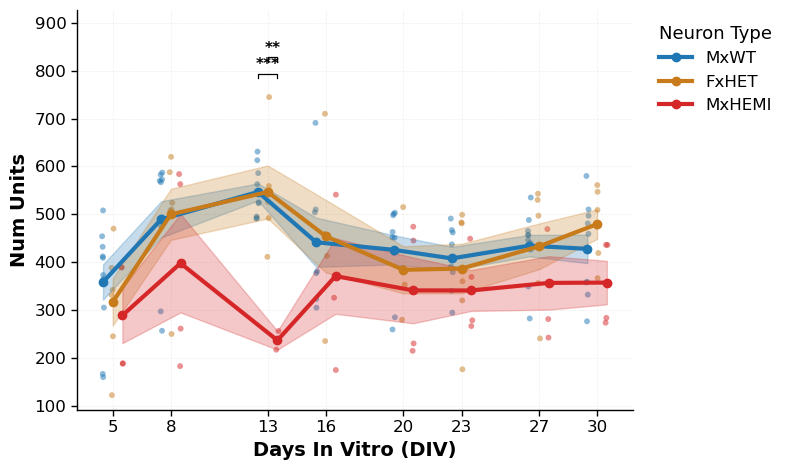

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

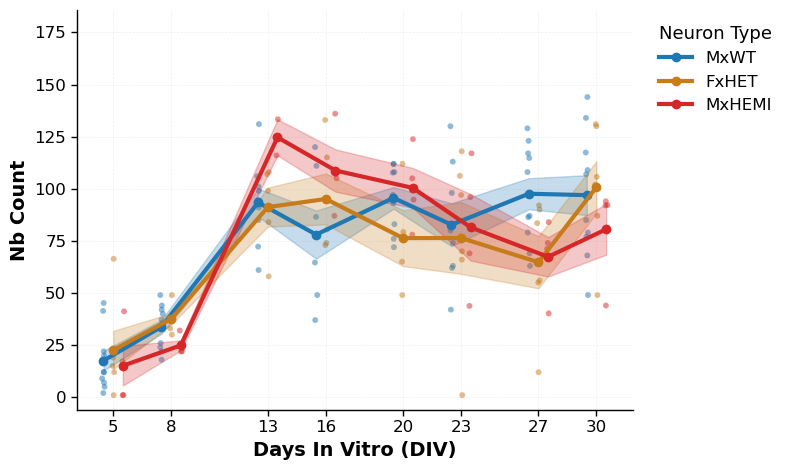

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

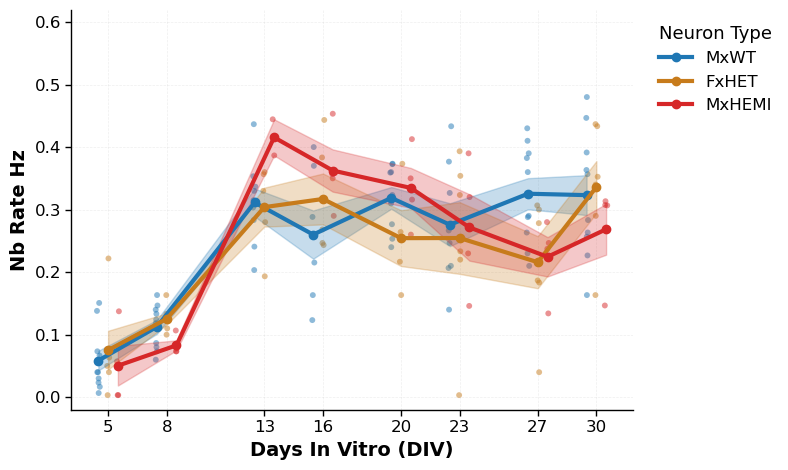

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

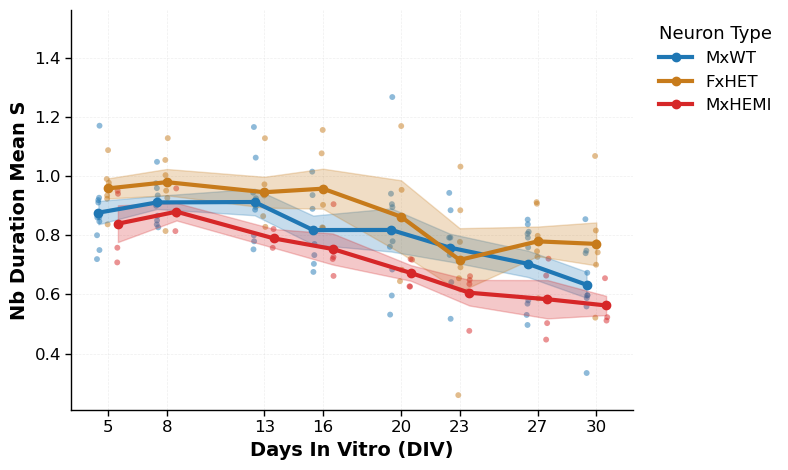

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

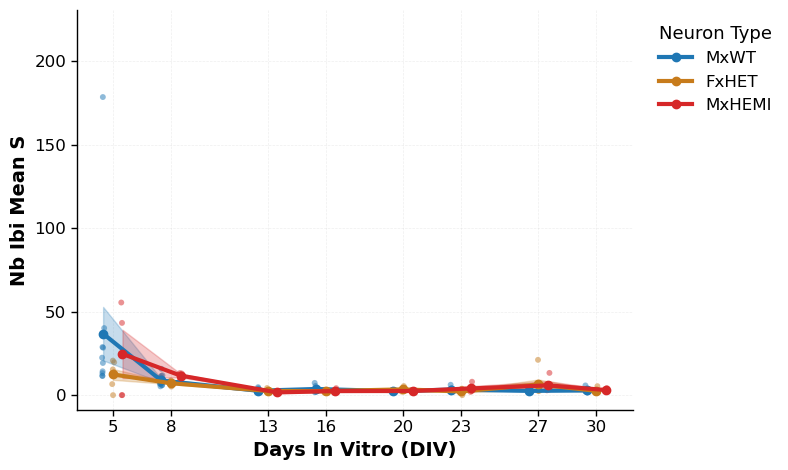

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

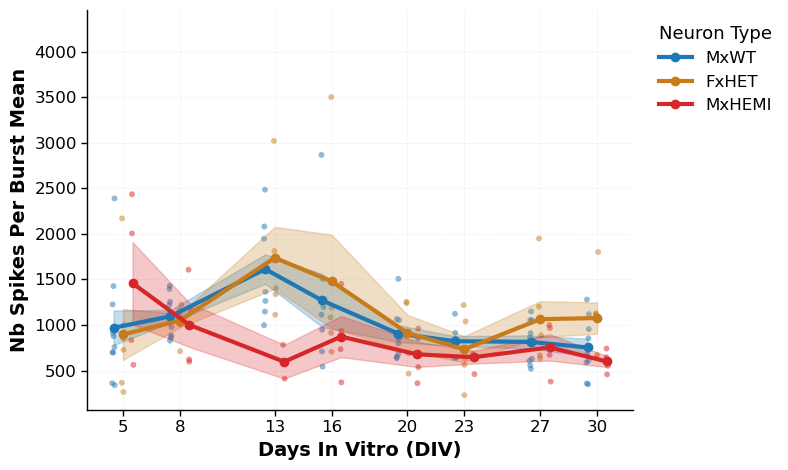

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

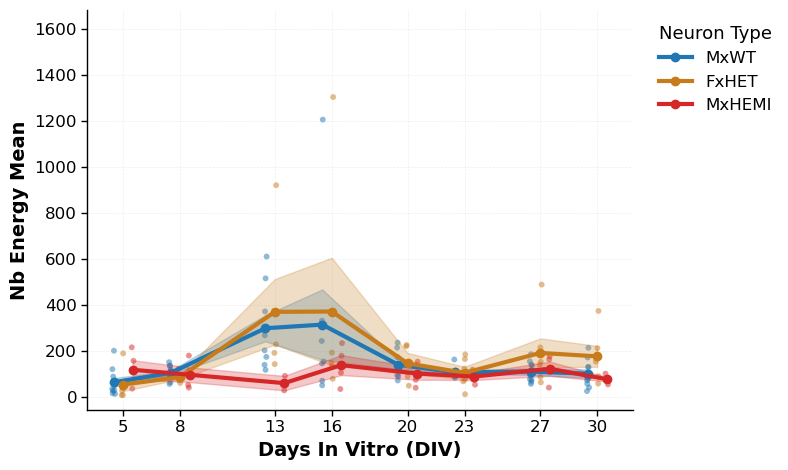

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

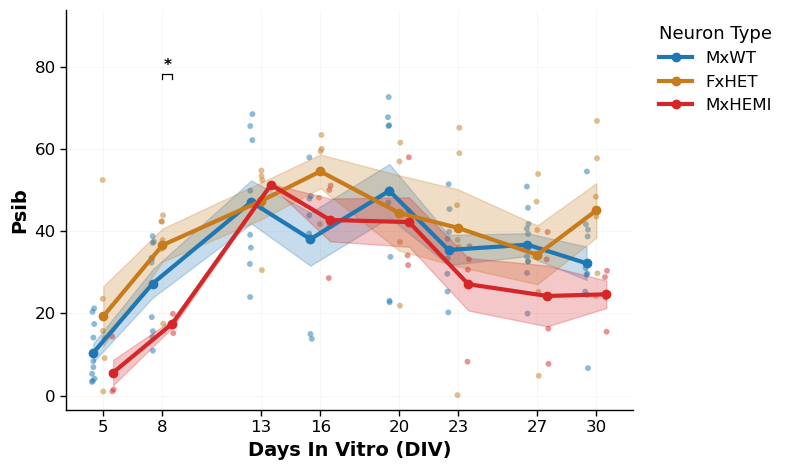

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

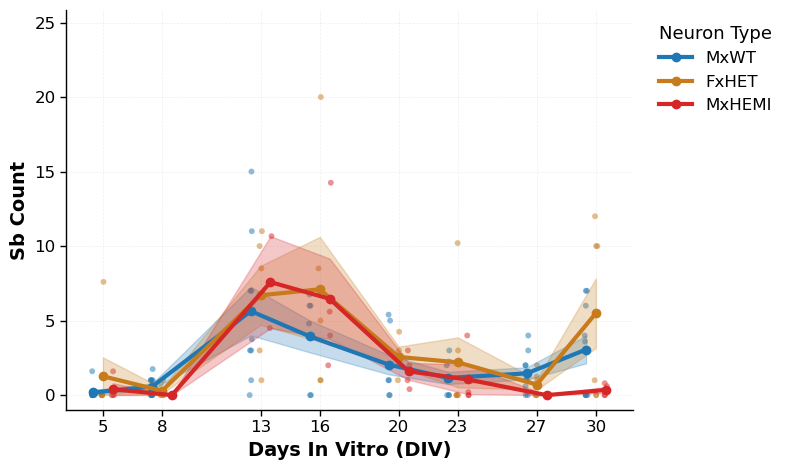

/global/homes/m/mpatil1/.conda/envs/spikeinterface/lib/python3.13/site-packages/pandas/core/groupby/generic.py:324: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f = lambda x: func(x, *args, **kwargs)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
fi

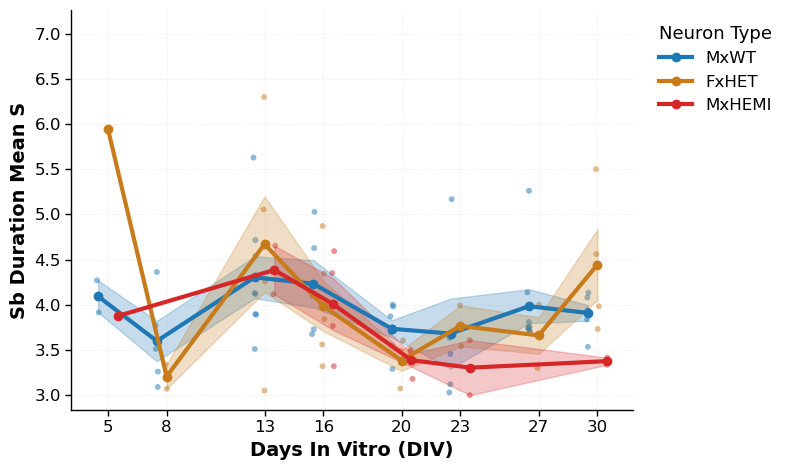

/global/homes/m/mpatil1/.conda/envs/spikeinterface/lib/python3.13/site-packages/pandas/core/groupby/generic.py:324: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f = lambda x: func(x, *args, **kwargs)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
fi

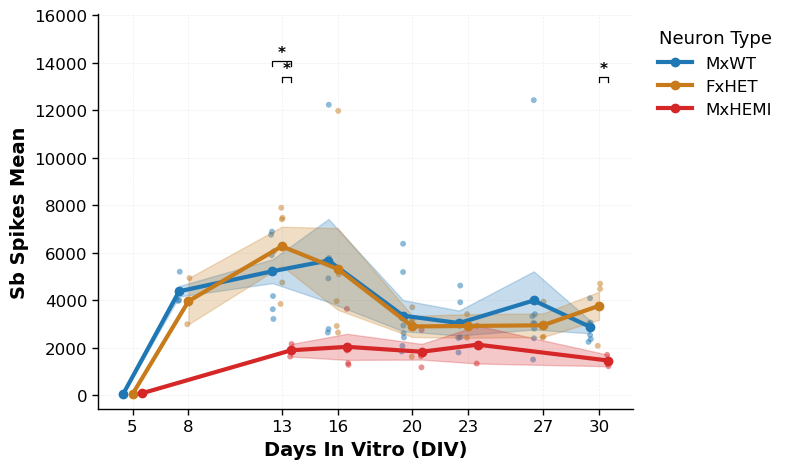

In [27]:
cols_to_plot = ['num_units', 'nb_count', 'nb_rate_hz', 'nb_duration_mean_s',
                'nb_ibi_mean_s', 'nb_spikes_per_burst_mean',
                'nb_energy_mean', 'psib', 'sb_count',
                'sb_duration_mean_s', 'sb_spikes_mean']
for col in cols_to_plot:
    plot_scalar_line_anova_tukey(
        merged_df,
        value_col=col,
        feature_label=col.replace('_', ' ').title(),
    )
